# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
# !pip install wandb -q
# !pip3 install pytorch_lightning torchmetrics -q

In [ ]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dgkomarov_hse. Use `wandb login --relogin` to force relogin


True

In [ ]:
from collections import defaultdict, namedtuple

import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-10-30 17:14:43--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-10-30 17:14:44--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf6e48028ce067f765b1b6f6749.dl.dropboxusercontent.com/cd/0/get/Bv06gzVAWcqb_DdnsPoBwNkh_pncnCqmSzv3PNzus0oxI9nhIrRqv7SYpjsiHXwPOAJXERc5wWFCU4xUwl317dKU6nPU5RZKBH7TjyitfdNZ6ktyGvPXxHAf6BwG2DzND3BQrvpJ-HjDcE7eBzAzC1r57f-1Ml38l7WDYUohHg5hKw/file?dl=1# [following]
--2022-10-30 17:14:44--  https://ucf6e48028ce067f765b1b6f6749.dl.dropboxusercontent.com/cd/0/get/Bv06gzVAWcqb_DdnsPoBwNkh_pncnCqmSzv3PNzus0oxI9nhIrRqv7SYpjsiHXwPOAJXERc5wWFCU4

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [ ]:
# Подсчитаем средние и стандартные отклонения по трем каналам
train_data = ImageFolder('/content/dataset/dataset/train', transform=transforms.Compose([transforms.ToTensor()]))

means, vars = [], []
for image, label in train_data:
    means.append(image.mean(dim=(1, 2)))
    vars.append(image.std(dim=(1, 2)))
print(f'mean channels: {torch.stack(means).mean(dim=0)}, std channels: {torch.stack(vars).mean(dim=0)}')

mean channels: tensor([0.4802, 0.4481, 0.3975]), std channels: tensor([0.2302, 0.2265, 0.2262])


In [ ]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))
    ]
)
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))

    ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

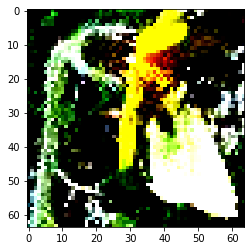

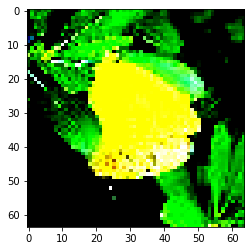

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
from torchvision.models import resnet18

### Гиперпараметры

In [ ]:
EPOCHS = 10
lr = 0.001

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, learning_rate, sch=False):
        super().__init__()
        self.sch = sch
        self.model = resnet18(pretrained=False, num_classes=200)
        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        if self.sch:
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=3, gamma=0.7)
            return [self.optimizer], [self.scheduler]
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
wandb_logger = WandbLogger(log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

module = YourModule(lr, True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(logger=wandb_logger,
                     accelerator="gpu",
                     max_epochs=EPOCHS,
                     callbacks=[lr_monitor])

trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.3 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.116    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model.forward(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

In [ ]:
# https://github.com/Lightning-AI/lightning/issues/924
def weights_update(model, checkpoint):
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

model = weights_update(model=module, checkpoint=torch.load('/content/task1_resnet18_0408'))

In [ ]:
accuracy = evaluate_task(model, val_dataloader)
print(f"\n\nОценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 40/40 [00:06<00:00,  5.80it/s]



Оценка за это задание составит 9.27 баллов


# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

https://wandb.ai/dgkomarov_hse/lightning_logs/reports/-2-1---VmlldzoyODg0NTEw?accessToken=ocdohohdt9r335kmpfbz8ppcnlri8h2i41va3yjv5f9dftx2ik1p0lyibcs8yxa8

**Веса модели**: https://drive.google.com/file/d/10lICwd7GgV8G2PhoRwqQwgL8ocnuOKcj/view?usp=sharing